## Activity 2.3 : Predicting HDB resale price
In this activity, we will learn:

*   HDB resale price dataset 
*   Load and preprocess the dataset
*   Split the dataset for training and testing
*   Define, compile and train a neural network model
*   Evaluate the model


### Resale Flat Prices
The Resale Flat Prices dataset can be downloaded at https://data.gov.sg/dataset/resale-flat-prices.  It contains the following data, month of the transaction, the town, flat type, block, street name, story range, floor area, flat model, lease commence date, remaining lease and Resale price. 

What we want to do is to train a neural network model that is able to predict the resale price of a particular HDB flat, given some information like town, lease commnce date and floor area for example.


### Mount Google Drive

Mount your Google Drive on your runtime using an authorization code.

Follow the instruction on the screen to authorise Colab accessing your drive. On your Google Drive, you can access you files prepend with “/content/drive/MyDrive/”

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# change working director
# %cd "/content/drive/MyDrive/Colab Notebooks/goML"

### Import necessary libraries and dataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

### Process the dataset

If you download the dataset from data.gov.sg, unzip the files and use resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv.  At the time of this writing, the file contains about 94k transaction records.  We pandas to read the file into a dataframe. As you can see, we use a separate copy so we do not need to reload everytime we alter the dataframe

In [4]:
file_url = "data/resale-flat-prices-from-jan-2017-onwards.csv"
data = pd.read_csv(file_url)
dataframe = data.copy()
dataframe.shape

(93818, 11)

Let us have a peek at the dataset

In [5]:
dataframe.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

Let's do some cleaning up of the dataset

In [6]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])

#Get storey range as a continuous number
dataframe['storey_range'] = dataframe['storey_range'].apply(lambda storey_range:storey_range[:2])

In [7]:
dataframe.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10           10   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4           01   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5           01   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10           04   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5           01   

   floor_area_sqm      flat_model  lease_commence_date remaining_lease  \
0            44.0        Improved                 1979              61   
1            67.0  New Generation                 1978              60   
2            67.0  New Generation                 1980              62   
3            68.0  New Generation                 1980              62   
4            67.0  New Generation                 1980              62   

   resale_price       date  year  
0      232000.0 2017-01-01  2017  
1      250000.0 2017-01-01  2017  
2      262000.0 2017-01-01  2017  
3      265000.0 2017-01-01  2017  
4      265000.0 2017-01-01  2017

**Geocoding**.  We would also like to geocode the addresses. However since geocoders usually have a limit to the amount of addresses we can geocode for free, I decided to geocode the towns only
We used Geopy and Geopanda as shown here https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [8]:
#Concat address
dataframe['address'] = dataframe['block'].map(str) + ', ' + dataframe['street_name'].map(str) + ', Singapore' 
dataframe.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10           10   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4           01   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5           01   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10           04   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5           01   

   floor_area_sqm      flat_model  lease_commence_date remaining_lease  \
0            44.0        Improved                 1979              61   
1            67.0  New Generation                 1978              60   
2            67.0  New Generation                 1980              62   
3            68.0  New Generation                 1980              62   
4            67.0  New Generation                 1980              62   

   resale_price       date  year                            address  
0      232000.0 2017-01-01  2017  406, ANG MO KIO AVE 10, Singapore  
1      250000.0 2017-01-01  2017   108, ANG MO KIO AVE 4, Singapore  
2      262000.0 2017-01-01  2017   602, ANG MO KIO AVE 5, Singapore  
3      265000.0 2017-01-01  2017  465, ANG MO KIO AVE 10, Singapore  
4      265000.0 2017-01-01  2017   601, ANG MO KIO AVE 5, Singapore

In [12]:
# !pip install geopandas 
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [13]:
#Geocode by town (Singapore is so small that geocoding by addresses might not make much difference compared to geocoding to town)

town = [x for x in dataframe['town'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(town)):
    # remove things that does not seem usefull here
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(town[i])
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the locatio, latitude and longitude
df_ = pd.DataFrame({'town':town, 
                    'latitude': latitude,
                    'longitude':longitude})
# merge on Restaurant_Location with rest_df to get the column 
dataframe = dataframe.merge(df_, on='town', how='left')

The geographical coordinate of location are 1.3700803, 103.8495228.
The geographical coordinate of location are 1.3239765, 103.930216.
The geographical coordinate of location are 29.5792182, 106.2019243.
The geographical coordinate of location are 1.3490572, 103.7495906.
The geographical coordinate of location are 4.5616942, 101.0240366.
The geographical coordinate of location are 1.3779175, 103.7630947.
The geographical coordinate of location are 1.3546901, 103.7763724.
The geographical coordinate of location are 36.5070827, -79.7447575.
The geographical coordinate of location are 1.3853167, 103.744325.
The geographical coordinate of location are 1.3151003, 103.7652311.
The geographical coordinate of location are 1.3181862, 103.8870563.
The geographical coordinate of location are 1.3708011, 103.89254433997465.
The geographical coordinate of location are 1.333108, 103.7422939.
The geographical coordinate of location are 1.34327875, 103.70422990775728.
The geographical coordinate of loc

In [14]:
dataframe.head()

month        town flat_type block        street_name storey_range  \
0      1  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10           10   
1      1  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4           01   
2      1  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5           01   
3      1  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10           04   
4      1  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5           01   

   floor_area_sqm      flat_model  lease_commence_date remaining_lease  \
0            44.0        Improved                 1979              61   
1            67.0  New Generation                 1978              60   
2            67.0  New Generation                 1980              62   
3            68.0  New Generation                 1980              62   
4            67.0  New Generation                 1980              62   

   resale_price       date  year                            address  latitude  \
0      232000.0 2017-01-01  2017  406, ANG MO KIO AVE 10, Singapore   1.37008   
1      250000.0 2017-01-01  2017   108, ANG MO KIO AVE 4, Singapore   1.37008   
2      262000.0 2017-01-01  2017   602, ANG MO KIO AVE 5, Singapore   1.37008   
3      265000.0 2017-01-01  2017  465, ANG MO KIO AVE 10, Singapore   1.37008   
4      265000.0 2017-01-01  2017   601, ANG MO KIO AVE 5, Singapore   1.37008   

    longitude  
0  103.849523  
1  103.849523  
2  103.849523  
3  103.849523  
4  103.849523

Next we can drop some columns which is not useful for us.

In [15]:
dataframe = dataframe.drop('date',axis=1)
dataframe = dataframe.drop('block',axis=1)
dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('address',axis=1)
dataframe = dataframe.drop('year',axis=1)

In [16]:
dataframe.head()

town flat_type storey_range  floor_area_sqm      flat_model  \
0  ANG MO KIO    2 ROOM           10            44.0        Improved   
1  ANG MO KIO    3 ROOM           01            67.0  New Generation   
2  ANG MO KIO    3 ROOM           01            67.0  New Generation   
3  ANG MO KIO    3 ROOM           04            68.0  New Generation   
4  ANG MO KIO    3 ROOM           01            67.0  New Generation   

  remaining_lease  resale_price  latitude   longitude  
0              61      232000.0   1.37008  103.849523  
1              60      250000.0   1.37008  103.849523  
2              62      262000.0   1.37008  103.849523  
3              62      265000.0   1.37008  103.849523  
4              62      265000.0   1.37008  103.849523

As we can see from the above table, we are now down to 9 columns.  However, we are still not able to feed these data to train our neural network model.  We need to encode those categorial data, e.g. "2 ROOM" into a numercal representation so that it can be computed on.  To do this, we will use pandas's get_dummy() to perform a one-hot encoding on these columns.  In one-hot encoding, an array of labelled data (from Red, Yellow and Greem in the example below) is transformed into a vector shown below:


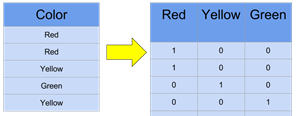

In [17]:
df_2 = pd.get_dummies(dataframe, columns=['town','flat_type','storey_range','flat_model'])
df_2.head()

floor_area_sqm remaining_lease  resale_price  latitude   longitude  \
0            44.0              61      232000.0   1.37008  103.849523   
1            67.0              60      250000.0   1.37008  103.849523   
2            67.0              62      262000.0   1.37008  103.849523   
3            68.0              62      265000.0   1.37008  103.849523   
4            67.0              62      265000.0   1.37008  103.849523   

   town_ANG MO KIO  town_BEDOK  town_BISHAN  town_BUKIT BATOK  \
0                1           0            0                 0   
1                1           0            0                 0   
2                1           0            0                 0   
3                1           0            0                 0   
4                1           0            0                 0   

   town_BUKIT MERAH  ...  flat_model_Multi Generation  \
0                 0  ...                            0   
1                 0  ...                            0   
2                 0  ...                            0   
3                 0  ...                            0   
4                 0  ...                            0   

   flat_model_New Generation  flat_model_Premium Apartment  \
0                          0                             0   
1                          1                             0   
2                          1                             0   
3                          1                             0   
4                          1                             0   

   flat_model_Premium Apartment Loft  flat_model_Premium Maisonette  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   

   flat_model_Simplified  flat_model_Standard  flat_model_Terrace  \
0                      0                    0                   0   
1                      0                    0                   0   
2                      0                    0                   0   
3                      0                    0                   0   
4                      0                    0                   0   

   flat_model_Type S1  flat_model_Type S2  
0                   0                   0  
1                   0                   0  
2                   0                   0  
3                   0                   0  
4                   0                   0  

[5 rows x 75 columns]

In [18]:
len(df_2.columns)

75

We see that now we have expanded the number of columns to 75.  Of which 74 columns will be used as features to train our model.  Can you guess which column is not used as a feature?

That's right.  Remember, resale_price is our "target" (some call it label) that we are trying to predict, so this is not a feature.  The following will split the dataset into features and traget. We typically pre-fix the features array with a "X" and the target array with a "y".

In [19]:
X = df_2.drop('resale_price',axis =1)
y = df_2['resale_price']
X=X.values
y=y.values

Next we will split the dataset such that 30% is used for evaluating the model and 70% is used for training the model.

In [20]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# Let us print the first element in the array to have a look at the data
print(X_train[0])

[123.0 '76' 1.3708011 103.89254433997465 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Next, we will use a MinMax scaler to transform the dataset. This scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.  Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. 

In [21]:
#Standard scaler - fit&transform on train, fit only on test
s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

C:\Users\kwseow\AppData\Local\Temp/ipykernel_16592/1546132320.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = s_scaler.fit_transform(X_train.astype(np.float))
C:\Users\kwseow\AppData\Local\Temp/ipykernel_16592/1546132320.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = s_scaler.transform(X_test.astype(np.float))


Let us take a look at the transformed data

In [22]:
print(X_train[0])

[0.44660194 0.60377358 0.48728092 0.75687028 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


### Linear Regression

In [23]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)

2.3439587985452756e+16
[ 7.27288644e+05  2.49297655e+05  9.40625669e+15 -8.02607120e+15
 -2.48718647e+14 -2.41733545e+14 -2.96422242e+15 -2.49652882e+14
 -6.49100293e+14 -2.52096721e+14 -2.49402380e+14 -9.25082204e+15
 -2.53393085e+14 -2.45827540e+14 -2.42461941e+14 -2.47493670e+14
 -2.48297327e+14 -2.50448761e+14 -2.44303639e+14 -2.40318403e+14
 -2.46005293e+14 -2.50595762e+14  6.28737221e+15 -2.57410970e+14
 -2.49491289e+14 -2.45983653e+14 -2.42065553e+14 -2.45285560e+14
 -1.11449557e+16 -2.55013104e+14 -2.47340034e+16 -2.47340034e+16
 -2.47340034e+16 -2.47340034e+16 -2.47340034e+16 -2.47340034e+16
 -1.07761993e+16 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15
 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15
 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15
 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15 -1.76655401e+15
 -1.76655401e+15 -1.76655401e+15  4.79966846e+15  4.79966846e+15
  4.79966846e+15  4.79966846e+15  4.79966846e+15  4.79966846e+15
  

In [24]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

Actual  Predicted
0      475000.0   458284.0
1      345000.0   329924.0
2      413000.0   448972.0
3      310000.0   347508.0
4      310000.0   280892.0
...         ...        ...
28141  570000.0   610156.0
28142  550000.0   580952.0
28143  238000.0   150148.0
28144  348000.0   416612.0
28145  578000.0   595788.0

[28146 rows x 2 columns]

In [25]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: 44530.900048319476
MSE: 3336896210.254228
RMSE: 57765.87409755199


### K Nearest Neighbours

In [26]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 42094.309435632495


### Ridge Regression


In [27]:
from sklearn.linear_model import Ridge

###
### add code to create Ridge regression
###

rr.fit(X_train,y_train)
predictions = rr.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

NameError: name 'rr' is not defined

### Lasso Regression

In [28]:
from sklearn.linear_model import Lasso
###
### add code to create Lasso regression
###

model_lasso.fit(X_train,y_train)
predictions = model_lasso.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

NameError: name 'model_lasso' is not defined

### Elastic Net Regression

In [29]:
from sklearn.linear_model import ElasticNet
###
### add code to create Elastic Net regression
###

model_enet.fit(X_train,y_train)
predictions = model_enet.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


NameError: name 'model_enet' is not defined

### Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
# having 9 neurons is based on the number of available features
model = Sequential()

###
### add code to create your neural network regression
###

model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [31]:
model.summary() 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
# Train the model
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    shuffle=True,
    verbose=2
)

Epoch 1/50
8209/8209 - 4s - loss: 222423400448.0000
Epoch 2/50
8209/8209 - 4s - loss: 222379917312.0000
Epoch 3/50
8209/8209 - 4s - loss: 222336008192.0000
Epoch 4/50
8209/8209 - 4s - loss: 222292623360.0000
Epoch 5/50
8209/8209 - 4s - loss: 222249762816.0000
Epoch 6/50
8209/8209 - 4s - loss: 222206410752.0000
Epoch 7/50
8209/8209 - 4s - loss: 222162403328.0000
Epoch 8/50
8209/8209 - 4s - loss: 222119100416.0000
Epoch 9/50
8209/8209 - 4s - loss: 222076174336.0000
Epoch 10/50
8209/8209 - 4s - loss: 222032166912.0000
Epoch 11/50
8209/8209 - 4s - loss: 221989339136.0000
Epoch 12/50
8209/8209 - 4s - loss: 221945741312.0000
Epoch 13/50
8209/8209 - 4s - loss: 221902323712.0000
Epoch 14/50
8209/8209 - 4s - loss: 221859250176.0000
Epoch 15/50
8209/8209 - 4s - loss: 221815652352.0000
Epoch 16/50
8209/8209 - 4s - loss: 221772087296.0000
Epoch 17/50
8209/8209 - 4s - loss: 221728473088.0000
Epoch 18/50
8209/8209 - 4s - loss: 221685956608.0000
Epoch 19/50
8209/8209 - 4s - loss: 221641981952.0000
Ep

In [ ]:
predictions = model.predict(X_test, verbose=0)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))